# Модуль2

## Часть 1

### 1.1

In [20]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [48]:
import numpy as np
import cv2

VIDEO_FILE = "./training_datasets/clock.mp4"
DESIRED_FRAMES_TO_SAVE = 43200


count = 0
cap = cv2.VideoCapture(VIDEO_FILE)

length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("FRAMES TOTAL LEN: ", length)

fps = cap.get(cv2.CAP_PROP_FPS)
print("FPS: ", fps)

duration_msec = cap.get(cv2.CAP_PROP_FRAME_COUNT) / fps * 1000
print("DURATION M SECONDS: ", duration_msec)

indices = range(DESIRED_FRAMES_TO_SAVE)
timestamps_msec = [k / DESIRED_FRAMES_TO_SAVE * duration_msec for k in indices]
#print("TIMESTAMPTS M SECONDS: ", timestamps_msec)

frames_saved = 0
while frames_saved < DESIRED_FRAMES_TO_SAVE:
    
    (ok, frame) = cap.read()
    if not ok:
        break

    timestamp_msec = cap.get(cv2.CAP_PROP_POS_MSEC)
    scheduled_msec = timestamps_msec[frames_saved]
    if timestamp_msec >= scheduled_msec:
        frame=cv2.resize(frame[10:350, 150:490], (128, 128))
        name = f'./raw_images/{timestamp_msec}_.jpg'
        cv2.imwrite(name, frame)
        if frames_saved%10000==0:
            print("Processing ", frames_saved)
        frames_saved += 1

cap.release()
cv2.destroyAllWindows()

FRAMES TOTAL LEN:  43200
FPS:  1.0
DURATION M SECONDS:  43200000.0
Processing  0
Processing  10000
Processing  20000
Processing  30000
Processing  40000


Кадры были преобразованы в картинки до размера 128 на 128 и сохранены 

In [22]:
import torch

In [49]:
import numpy as np
import matplotlib.pyplot as plot
import os
from random import randint
import math
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as Func
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import random
from tqdm.notebook import tqdm
from plotly import graph_objs as go
import plotly.offline as ofl

In [50]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

In [51]:
device = torch.device("cuda:0")

In [54]:
time=np.arange(0.0,43199000.0,1000)

## Часть 2

In [1]:
import numpy as np 
import pandas as pd
import glob
import os
import librosa
import librosa.display
from librosa.util import normalize
import matplotlib.pyplot as plt

In [9]:
waveform, sr = librosa.load("./training_datasets/audio.wav", sr = 22050)
print('Sample rate: {} Min value: {:.6f} Max value: {:.6f} Avg value: {:.6f}'.format(sr, waveform.min(), waveform.max(), waveform.mean()))

Sample rate: 22050 Min value: -1.187734 Max value: 1.173684 Avg value: 0.000034


Загрузил файл

### 2.1
Построили спектрограмму


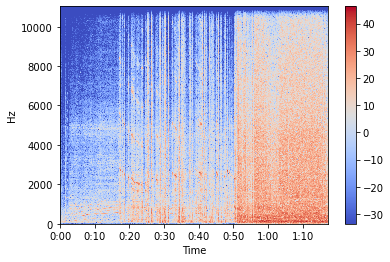

In [11]:
X = librosa.stft(waveform)
s = librosa.amplitude_to_db(abs(X))
ld.specshow(s, sr=sr, x_axis = 'time', y_axis='linear')
plt.colorbar()

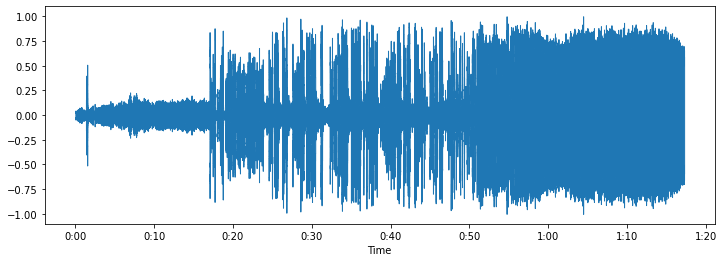

In [8]:
import matplotlib.pyplot as plt
import librosa.display as ld
plt.figure(figsize=(12,4))
ld.waveshow(waveform, sr=sr)

### 2.2
Применим быстрое преобразование Фурье

Text(0, 0.5, 'Amplitude')

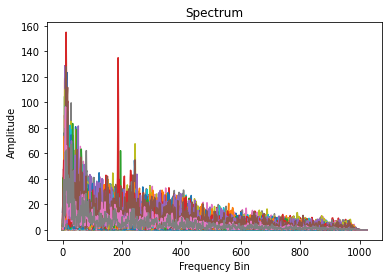

In [35]:
n_fft = 22050
ft = np.abs(librosa.stft(waveform, hop_length = n_fft+1))
plt.plot(ft)
plt.title('Spectrum')
plt.xlabel('Frequency Bin')
plt.ylabel('Amplitude')

Видим много низких частот и мало высоких, а так же провал между частотой 0-200

Вывел амплитудный диапазон для первых 60000 точек

Text(0, 0.5, 'Amplitude')

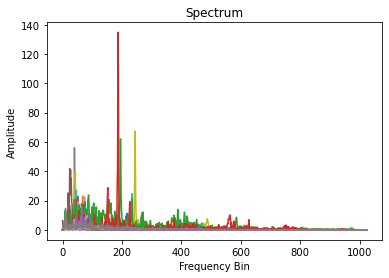

In [30]:
n_fft = 22050 
ft = np.abs(librosa.stft(waveform[:600000], hop_length = n_fft+1))
plt.plot(ft)
plt.title('Spectrum')
plt.xlabel('Frequency Bin')
plt.ylabel('Amplitude')

Вывел амплитудный диапазон для последних 60000 точек

Text(0, 0.5, 'Amplitude')

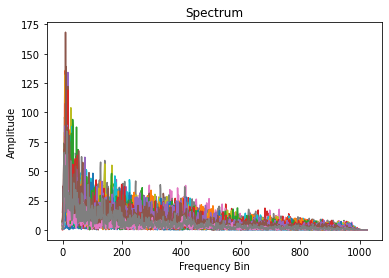

In [32]:
n_fft = 22050 
ft = np.abs(librosa.stft(waveform[-1*600000:], hop_length = n_fft+1))
plt.plot(ft)
plt.title('Spectrum')
plt.xlabel('Frequency Bin')
plt.ylabel('Amplitude')

Из графиков можно сделать вывод о присутствии значимых частот на всех частотах

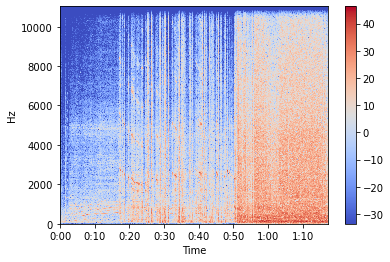

In [37]:
X = librosa.stft(waveform)
s = librosa.amplitude_to_db(abs(X))
ld.specshow(s, sr=sr, x_axis = 'time', y_axis='linear')
plt.colorbar()

### 2.3
Полосы на спектрограмме только подвердили наши догадки
Далее как агрегирующие характеристики будем использовать Мел-кепcтральные коэффициенты 

In [41]:
mfccs = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc = 40, hop_length=1024)
mfccs

array([[-311.0411   , -311.254    , -301.65662  , ...,   73.64978  ,
          80.40217  ,   81.97749  ],
       [ 135.5781   ,  143.8244   ,  126.36342  , ...,   82.25839  ,
          73.86576  ,   85.601746 ],
       [  10.597657 ,    7.482771 ,   10.627192 , ...,  -10.348049 ,
         -14.541401 ,   -3.4409218],
       ...,
       [  -3.0764294,   -0.8576956,    5.3923645, ...,    7.0485306,
          -1.5937924,    2.9930449],
       [  -2.8840363,    1.2891808,    6.7515693, ...,   -3.5001707,
         -10.847652 ,   -4.380966 ],
       [   1.3299605,    2.4314754,   -5.3528957, ...,    1.8015494,
          -4.885602 ,   -2.6955848]], dtype=float32)

hop_length=1024 это размер шага, наш размер дискретизации, n_mfcc = 40 станадартное значение, по заданию не менее 5

In [42]:
mfccs.shape

(40, 1664)

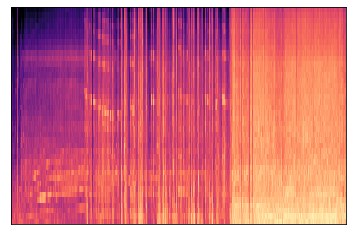

In [49]:
melspectrum = librosa.feature.melspectrogram(y=waveform, sr = sr,hop_length =1024, n_mels = 40)
librosa.display.specshow(librosa.power_to_db(melspectrum, ref=np.max))


### 2.4

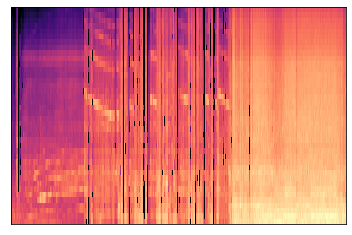

In [77]:
from scipy.signal import savgol_filter

melspectrum= savgol_filter(melspectrum,11,3)
librosa.display.specshow(librosa.power_to_db(melspectrum, ref=np.max))

Применим фильтр Савицкого-Голея для сглаживания

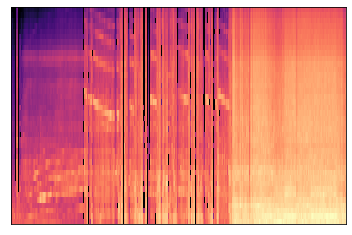

In [81]:
from scipy.ndimage import gaussian_filter1d
melspectrum= gaussian_filter1d(melspectrum,0.05)
librosa.display.specshow(librosa.power_to_db(melspectrum, ref=np.max))

Выполнили сглаживание по методу скользящего среднего

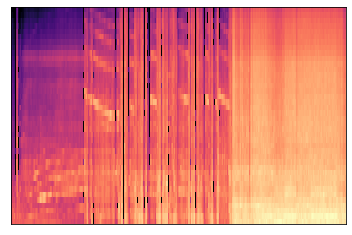

In [86]:
from scipy.ndimage import uniform_filter1d

melspectrum = uniform_filter1d(melspectrum, size=4)
librosa.display.specshow(librosa.power_to_db(melspectrum, ref=np.max))

##  Часть 3

In [87]:
df=pd.read_csv('./training_datasets/higgs.csv')

C:\Users\Admin\AppData\Local\Temp\ipykernel_6732\1905813615.py:1: DtypeWarning: Columns (20,21,22,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('./training_datasets/higgs.csv')


In [88]:
df.head()

,is_boson,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1pt,jet1eta,jet1phi,jet1b-tag,...,jet4eta,jet4phi,jet4b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.0,0.30222,0.833048,0.9857,0.978098,0.779732,0.992356,0.798343
1,1,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.0,0.909753,1.10833,0.985692,0.951331,0.803252,0.865924,0.780118
2,0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.0,0.946652,1.028704,0.998656,0.728281,0.8692,1.026736,0.957904
3,1,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.0,0.755856,1.361057,0.98661,0.838085,1.133295,0.872245,0.808487
4,0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,...,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98050 entries, 0 to 98049
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   is_boson                  98050 non-null  int64  
 1   lepton_pT                 98050 non-null  float64
 2   lepton_eta                98050 non-null  float64
 3   lepton_phi                98050 non-null  float64
 4   missing_energy_magnitude  98050 non-null  float64
 5   missing_energy_phi        98050 non-null  float64
 6   jet1pt                    98050 non-null  float64
 7   jet1eta                   98050 non-null  float64
 8   jet1phi                   98050 non-null  float64
 9   jet1b-tag                 98050 non-null  float64
 10  jet2pt                    98050 non-null  float64
 11  jet2eta                   98050 non-null  float64
 12  jet2phi                   98050 non-null  float64
 13  jet2b-tag                 98050 non-null  float64
 14  jet3pt

In [94]:
obj_hdrs=['jet4phi','jet4b-tag','m_jj','m_jjj','m_lv',' m_jlv','m_bb','m_wbb','m_wwbb']

In [95]:
for i in obj_hdrs:
    df[i] = pd.to_numeric(df[i], errors = 'coerce')
df.dropna(inplace = True)

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98049 entries, 0 to 98048
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   is_boson                  98049 non-null  int64  
 1   lepton_pT                 98049 non-null  float64
 2   lepton_eta                98049 non-null  float64
 3   lepton_phi                98049 non-null  float64
 4   missing_energy_magnitude  98049 non-null  float64
 5   missing_energy_phi        98049 non-null  float64
 6   jet1pt                    98049 non-null  float64
 7   jet1eta                   98049 non-null  float64
 8   jet1phi                   98049 non-null  float64
 9   jet1b-tag                 98049 non-null  float64
 10  jet2pt                    98049 non-null  float64
 11  jet2eta                   98049 non-null  float64
 12  jet2phi                   98049 non-null  float64
 13  jet2b-tag                 98049 non-null  float64
 14  jet3pt

Исправил проблему с типами

In [97]:
df.isnull().sum()

is_boson                    0
lepton_pT                   0
lepton_eta                  0
lepton_phi                  0
missing_energy_magnitude    0
missing_energy_phi          0
jet1pt                      0
jet1eta                     0
jet1phi                     0
jet1b-tag                   0
jet2pt                      0
jet2eta                     0
jet2phi                     0
jet2b-tag                   0
jet3pt                      0
jet3eta                     0
jet3phi                     0
jet3b-tag                   0
jet4pt                      0
jet4eta                     0
jet4phi                     0
jet4b-tag                   0
m_jj                        0
m_jjj                       0
m_lv                        0
 m_jlv                      0
m_bb                        0
m_wbb                       0
m_wwbb                      0
dtype: int64

In [99]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df = scaler.fit_transform(df)

Text(0, 0.5, 'Inertia')

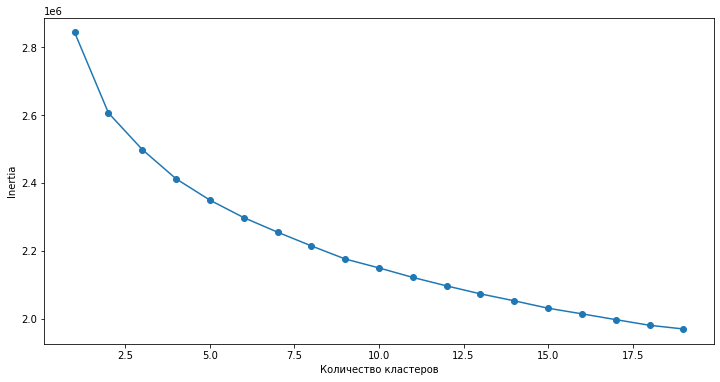

In [103]:
from sklearn.cluster import KMeans
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(df)
    SSE.append(kmeans.inertia_)

frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')

В качестве метрики используется инерция — мера того, насколько хорошо данные были разбиты на кластеры


In [110]:
kmeans = KMeans(n_clusters = 4, init='k-means++')
kmeans.fit(df)
pred = kmeans.predict(df)

In [120]:
df['Label'] = np.array(pred)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [118]:
sns.scatterplot(df['is_boson'] ,df['lepton_eta'] , hue = df['Label'] , palette = sns.color_palette('hls',4))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices